In [2]:
# Imports
import numpy as np
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
from arch import arch_model
from sklearn.metrics import mean_squared_error
import datetime
import time
import matplotlib.pyplot as plt
from numba import jit
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Retrieve SP500 adjusted closing daily price data for period of 2015-2021 
stocks = '^GSPC'
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')['Adj Close']
s_p500.tail(10)

[*********************100%***********************]  1 of 1 completed


Date
2020-12-16    3701.169922
2020-12-17    3722.479980
2020-12-18    3709.409912
2020-12-21    3694.919922
2020-12-22    3687.260010
2020-12-23    3690.010010
2020-12-24    3703.060059
2020-12-28    3735.360107
2020-12-29    3727.040039
2020-12-30    3732.040039
Name: Adj Close, dtype: float64

In [24]:
# # Retrieve SP500 adjusted closing daily price data for period of 2015-2021 
# stocks = '^GSPC'
# start = datetime.datetime(2015, 1, 1)
# end = datetime.date.today()
# s_p500 = yf.download(stocks, start=start, end = end, interval='1d')['Adj Close']
# s_p500.tail(10)

In [25]:
# Multiply by 100 to achieve better convergence during optimization process and compute realized volatility with window length of 5
ret = 100 * (s_p500.pct_change()[1:])
realized_vol = ret.rolling(5).std()

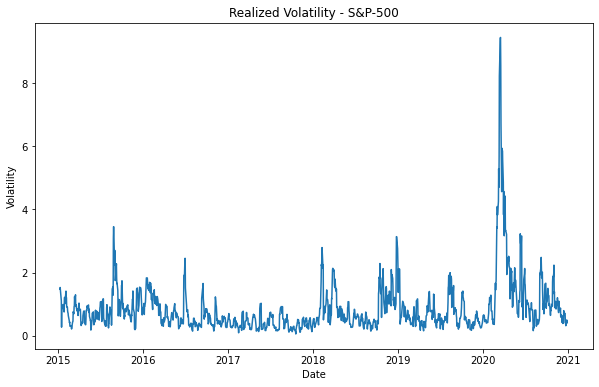

In [26]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized Volatility - S&P-500') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()

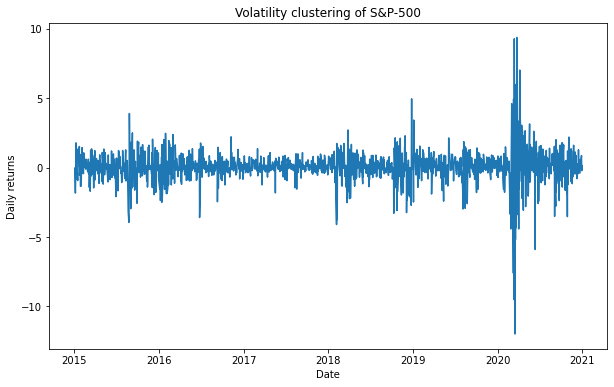

In [27]:
# Plot volatility clustering
plt.figure(figsize=(10,6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500') 
plt.ylabel('Daily returns')
plt.xlabel('Date') 
plt.show()

In [28]:
# Convert df to numpy array and define test set length
n = 252
split_date = ret.iloc[-n:].index
retv = ret.values

In [29]:
# Identify initial optimisation values
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(0.7217751313837741, 0.4777999668191871)

In [30]:
# Apply maximum log -likelihood method
@jit(nopython=True,parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

In [31]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

699.1261689983131

In [32]:
# Initial optimisation usining minimize package to obtain optimum ARCH parameters
def opt_params(x0, ret):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (ret),
                              method='Nelder-Mead', options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format(''.join(['-']*28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [33]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
 final_simplex: (array([[0.57936811, 0.61836641],
       [0.57937004, 0.61829395],
       [0.57927651, 0.6183971 ]]), array([692.21727257, 692.2172731 , 692.21727569]))
           fun: 692.2172725693592
       message: 'Optimization terminated successfully.'
          nfev: 49
           nit: 25
        status: 0
       success: True
             x: array([0.57936811, 0.61836641])

Resulting params = [0.57936811 0.61836641]


In [34]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -2079.74
Distribution:                  Normal   AIC:                           4163.48
Method:            Maximum Likelihood   BIC:                           4174.12
                                        No. Observations:                 1510
Date:                Wed, Apr 13 2022   Df Residuals:                     1510
Time:                        08:42:23   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5793  5.348e-02     10.832  2.426e-27 [  0.474,  0.68

In [35]:
# Determine optimum values with lowest Bayesian Information Criteria (bic) values
bic_arch = []
for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
arch = arch_model(ret, mean='Constant',vol='ARCH', p=p).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1859.56
Distribution:                  Normal   AIC:                           3731.12
Method:            Maximum Likelihood   BIC:                           3763.04
                                        No. Observations:                 1510
Date:                Wed, Apr 13 2022   Df Residuals:                     1509
Time:                        08:42:23   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0829  1.778e-02      4.664  3.109e-06 [4.807e-0

In [36]:
# Assess perfomance of model using realized volatility as benchmark
rmse_arch = np.sqrt(mean_squared_error(realized_vol[-n:]/100, 
                                       np.sqrt(forecast_arch.variance.iloc[-len(split_date):]/100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.1895


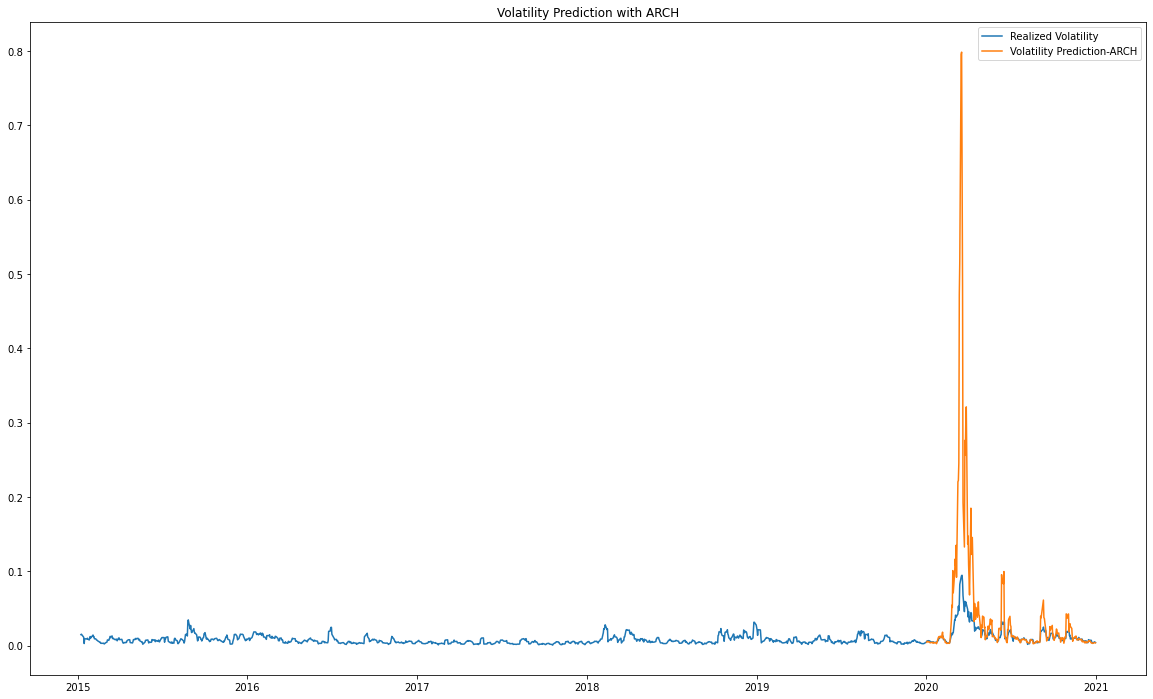

In [37]:
plt.figure(figsize=(20, 12))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()